# CNN

## Imports

Nothing to see here.

In [1]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

In [2]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, losses, models

from src.util import (
    load_star_galaxy_dataset,
    star_galaxy_split,
    train_val_test_split,
    STAR,
    GALAXY,
)

%matplotlib inline

## Dataset

### Load Dataset

Here we load the whole dataset and store the target values as constants.

In [3]:
# Load dataset
dataset = load_star_galaxy_dataset()
print(f"{dataset.DESCR}\n")
print(f"Dataset size: {len(dataset.image)} images")

This is a simple dataset consisting of ~3000 64x64 images of stars and ~1000 images of galaxies. The images were captured by the in-house 1.3m telescope of the observatory situated in Devasthal, Nainital, India.

Dataset size: 3986 images


In [4]:
def plot_images(
    images,
    labels,
    ncols: int = 1,
    color: str = "black",
) -> None:
    """Helper function to show images."""

    n = len(images)
    fig = plt.figure(figsize=(8, 8))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        a = fig.add_subplot(int(np.ceil(n / ncols)), ncols, i + 1)
        a.imshow(img, cmap="gray")
        a.set_title(lbl, color=color)
        a.axis("off")
    plt.show()

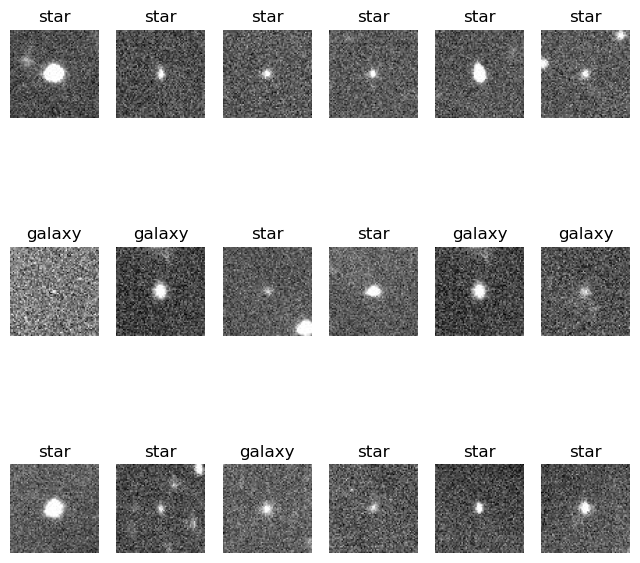

In [5]:
indices = np.random.choice(len(dataset.image), size=18)
plot_images(
    images=dataset.image[indices],
    labels=dataset.target_names[dataset.target[indices]],
    ncols=6,
)

## Building the Layers

Much like an onion or an ogre, a CNN model consists of layers.

The first few layers work with the input images more intuitively. The model takes in grayscale images, rescaling the `[0, 255]` values to `[0, 1]` (in both training and inference).

It also (in training) randomly flips and rotates images. This is helpful to the model since we have a relatively small dataset.

In [6]:
def create_model() -> tf.keras.Model:
    model = models.Sequential(
        [
            # Input Layers
            layers.Input(shape=(64, 64, 1), name="input"),
            layers.Rescaling(scale=(1.0 / 255), name="rescale"),
            # layers.RandomFlip(name="flip"),
            # layers.RandomRotation(factor=0.2, name="rotate"),
            # Convolution Layers
            layers.Conv2D(
                filters=32, kernel_size=3, activation="relu", name="conv2d_1"
            ),
            layers.Conv2D(
                filters=64, kernel_size=3, activation="relu", name="conv2d_2"
            ),
            layers.MaxPool2D(pool_size=2, name="maxpool_1"),
            layers.Dropout(rate=0.25, name="dropout_1"),
            layers.Conv2D(
                filters=64, kernel_size=3, activation="relu", name="conv2d_3"
            ),
            layers.MaxPool2D(pool_size=2, name="maxpool_2"),
            layers.Dropout(rate=0.25, name="dropout_2"),
            layers.Conv2D(
                filters=128, kernel_size=3, activation="relu", name="conv2d_4"
            ),
            layers.MaxPool2D(pool_size=2, name="maxpool_3"),
            layers.Dropout(rate=0.25, name="dropout_3"),
            # Deep Learning Layers
            layers.Flatten(name="flatten"),
            layers.Dense(
                units=1024,
                activation="relu",
                name="dense_1",
            ),
            # layers.Dense(
            #     units=32,
            #     activation="relu",
            #     name="dense_2",
            # ),
            layers.Dropout(rate=0.5, name="dropout_4"),
            # Output Layer
            layers.Dense(units=2, name="output"),
        ]
    )

    model.compile(
        optimizer="adam",
        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

In [7]:
model = create_model()

Now, let's see the model's layers.

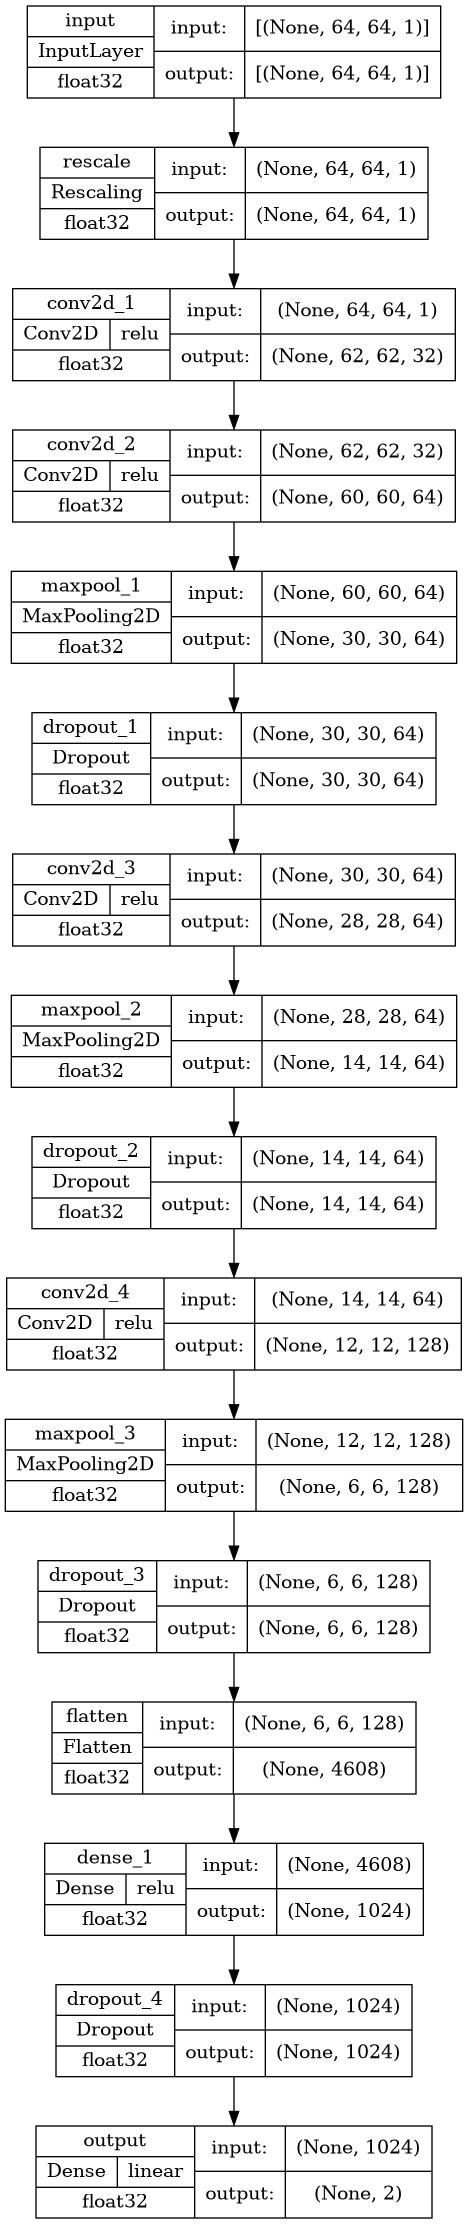

In [8]:
tf.keras.utils.plot_model(
    model=model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
)

## Training the Model

In [9]:
def train_test_model(model, x, y, epochs: int = 30):
    # Split dataset
    x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
        x,
        y,
        stratify=y,
    )

    # Train model
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=2,
    )

    # Evaluate model
    for _x, _y, _name in zip(
        [dataset.image, x, x_train, x_val, x_test],
        [dataset.target, y, y_train, y_val, y_test],
        ["FULL", "GIVEN", "TRAIN", "VAL", "TEST"],
    ):
        print()
        n = len(_x)
        label = f"{_name} ({n})"
        print(label)
        print("-" * len(label))
        print(f"overall ({n})", end="\t")
        model.evaluate(_x, _y, verbose=2)

        stars, galaxies = star_galaxy_split(_x, _y)
        n_stars, n_galaxies = len(stars), len(galaxies)
        print(f"stars ({n_stars})", end="\t")
        model.evaluate(stars, np.full(len(stars), STAR), verbose=2)
        print(f"galaxies ({n_galaxies})", end="\t")
        model.evaluate(galaxies, np.full(len(galaxies), GALAXY), verbose=2)

    return history

In [10]:
def plot_history(history) -> None:
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel("epoch")
    plt.show()

In [11]:
history = train_test_model(model=model, x=dataset.image, y=dataset.target)

Epoch 1/30
100/100 - 8s - loss: 0.5590 - accuracy: 0.7632 - val_loss: 0.5887 - val_accuracy: 0.7519 - 8s/epoch - 80ms/step
Epoch 2/30
100/100 - 7s - loss: 0.4810 - accuracy: 0.7748 - val_loss: 0.3771 - val_accuracy: 0.8195 - 7s/epoch - 72ms/step
Epoch 3/30
100/100 - 7s - loss: 0.3566 - accuracy: 0.8466 - val_loss: 0.3584 - val_accuracy: 0.8396 - 7s/epoch - 71ms/step
Epoch 4/30
100/100 - 7s - loss: 0.3294 - accuracy: 0.8563 - val_loss: 0.3459 - val_accuracy: 0.8697 - 7s/epoch - 71ms/step
Epoch 5/30
100/100 - 7s - loss: 0.3064 - accuracy: 0.8692 - val_loss: 0.3138 - val_accuracy: 0.8747 - 7s/epoch - 72ms/step
Epoch 6/30
100/100 - 7s - loss: 0.2952 - accuracy: 0.8758 - val_loss: 0.3106 - val_accuracy: 0.8772 - 7s/epoch - 71ms/step
Epoch 7/30
100/100 - 7s - loss: 0.2872 - accuracy: 0.8808 - val_loss: 0.3240 - val_accuracy: 0.8722 - 7s/epoch - 72ms/step
Epoch 8/30
100/100 - 7s - loss: 0.2731 - accuracy: 0.8877 - val_loss: 0.3219 - val_accuracy: 0.8672 - 7s/epoch - 71ms/step
Epoch 9/30
100/1

## Evaluating the Model

Let's see how the model performed with each epoch.

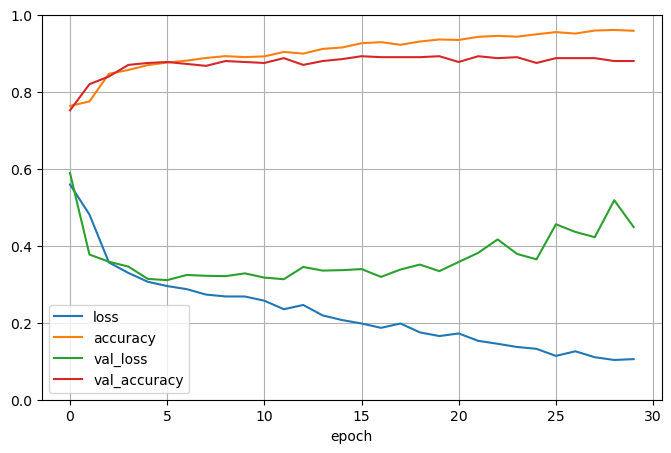

In [12]:
plot_history(history=history)

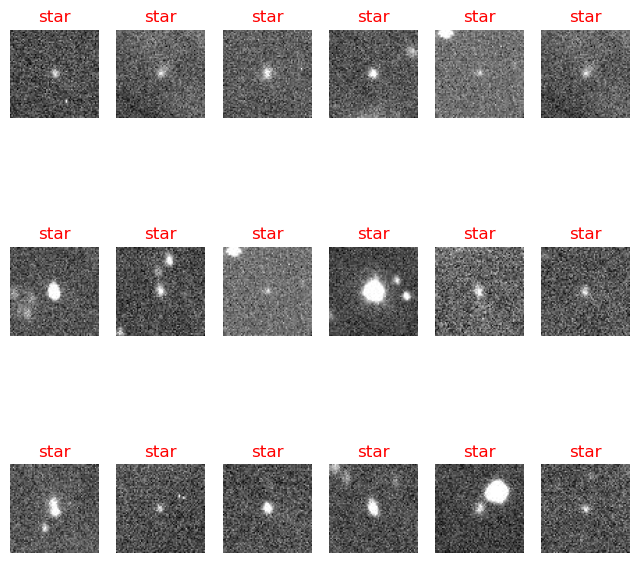

In [13]:
y_preds = np.argmax(model.predict(dataset.image, verbose=0), axis=1)
mispreds = dataset.image[y_preds != dataset.target]

indices = np.random.choice(len(mispreds), size=18)
plot_images(
    images=mispreds[indices],
    labels=dataset.target_names[dataset.target[indices]],
    ncols=6,
    color="red",
)

In [14]:
def plot_conf_matrix(cm, labels):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    cmap = plt.get_cmap("Blues")

    fig = plt.figure()
    axs = fig.add_subplot(111)

    cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
    thresh = np.max(cm) / 1.5

    caxs = axs.matshow(cm, interpolation="nearest", cmap=plt.get_cmap("Blues"))
    fig.colorbar(caxs)

    plt.title("Confusion Matrix")
    plt.xlabel(f"Predicted label\naccuracy={accuracy:0.4}; misclass={misclass:0.4}")
    plt.ylabel("True label")

    ticklabels = np.concatenate(([""], labels))
    axs.set_xticklabels(ticklabels)
    axs.set_yticklabels(ticklabels)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            f"{cm[i,j]:0.4}",
            ha="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.show()

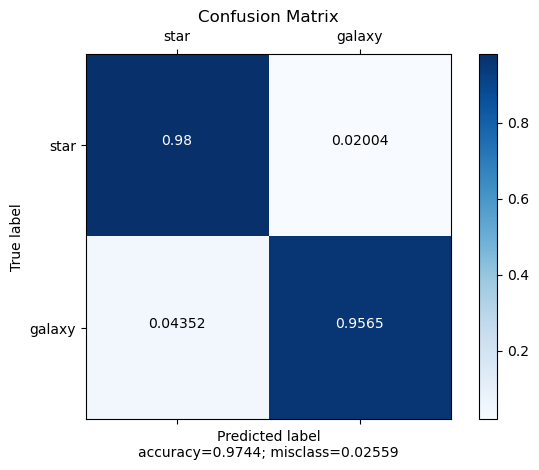

In [15]:
conf_matrix = tf.math.confusion_matrix(
    dataset.target,
    y_preds,
    num_classes=2,
)

plot_conf_matrix(cm=conf_matrix, labels=dataset.target_names)

## Problem

The dataset we use has far more images of stars than galaxies, almost 3 times as many. This presents a challenge when it comes to classification, as the model could easily guess "star" for any given image and have essentially a 1/4 chance of being right.

In [16]:
all_stars, all_galaxies = star_galaxy_split(dataset.image, dataset.target)
print(f"stars: {len(all_stars)} images")
print(f"galaxies: {len(all_galaxies)} images")

stars: 3044 images
galaxies: 942 images


## Attempt at a Solution

Our attempt at| solving this problem is to only use a subset of the entire dataset. We use a sample of about 1,000 random images of the stars, to have an even number of both classes in training and testing.

In [17]:
dataset_even = load_star_galaxy_dataset(even=True)
print(f"'Even' dataset size: {len(dataset_even.image)} images")

'Even' dataset size: 1884 images


In [18]:
model_even = create_model()

history_even = train_test_model(
    model=model_even, x=dataset_even.image, y=dataset_even.target
)

Epoch 1/30
48/48 - 4s - loss: 0.6956 - accuracy: 0.4997 - val_loss: 0.6898 - val_accuracy: 0.5266 - 4s/epoch - 83ms/step
Epoch 2/30
48/48 - 3s - loss: 0.6624 - accuracy: 0.5786 - val_loss: 0.6028 - val_accuracy: 0.6383 - 3s/epoch - 71ms/step
Epoch 3/30
48/48 - 3s - loss: 0.5156 - accuracy: 0.7551 - val_loss: 0.5614 - val_accuracy: 0.7394 - 3s/epoch - 71ms/step
Epoch 4/30
48/48 - 3s - loss: 0.4840 - accuracy: 0.7770 - val_loss: 0.4615 - val_accuracy: 0.7606 - 3s/epoch - 71ms/step
Epoch 5/30
48/48 - 3s - loss: 0.4896 - accuracy: 0.7797 - val_loss: 0.4704 - val_accuracy: 0.7926 - 3s/epoch - 70ms/step
Epoch 6/30
48/48 - 3s - loss: 0.4288 - accuracy: 0.8089 - val_loss: 0.4815 - val_accuracy: 0.7766 - 3s/epoch - 71ms/step
Epoch 7/30
48/48 - 3s - loss: 0.4258 - accuracy: 0.8142 - val_loss: 0.4897 - val_accuracy: 0.7713 - 3s/epoch - 71ms/step
Epoch 8/30
48/48 - 3s - loss: 0.4235 - accuracy: 0.8155 - val_loss: 0.4825 - val_accuracy: 0.7553 - 3s/epoch - 71ms/step
Epoch 9/30
48/48 - 3s - loss: 0.

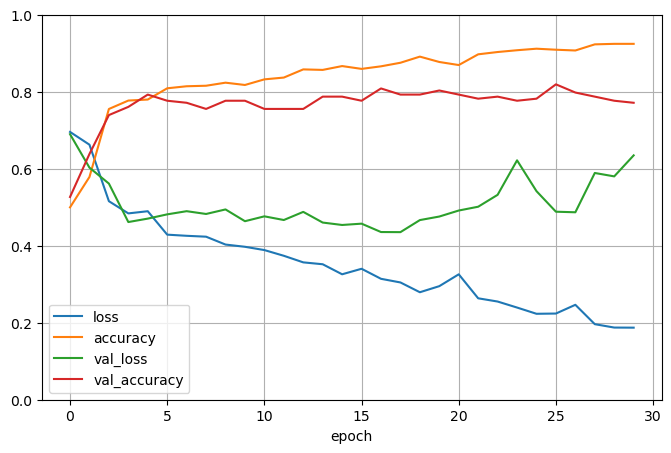

In [19]:
plot_history(history=history_even)

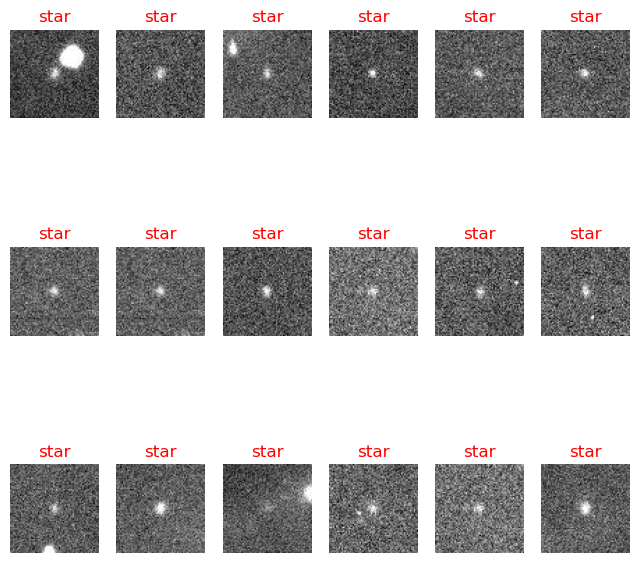

In [20]:
y_preds_even = np.argmax(model_even.predict(dataset.image, verbose=0), axis=1)
mispreds_even = dataset.image[y_preds != dataset.target]

indices = np.random.choice(len(mispreds), size=18)
plot_images(
    images=mispreds[indices],
    labels=dataset.target_names[dataset.target[indices]],
    ncols=6,
    color="red",
)

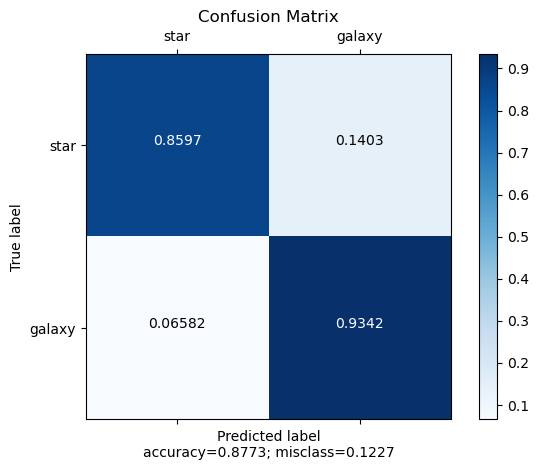

In [21]:
conf_matrix_even = tf.math.confusion_matrix(
    dataset.target,
    y_preds_even,
    num_classes=2,
)

plot_conf_matrix(cm=conf_matrix_even, labels=dataset.target_names)

## Conclusions

TBD